In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import cdist
from scipy.stats import zscore, norm

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

from sklearn import metrics

In [2]:
sns.set_style("darkgrid")

# World Data CSV

We are going to look at our world data again.

In [3]:
world_data=pd.read_csv('WorldData.csv').drop(['Unnamed: 0'],axis=1)
world_data.head()

,Country,Year,Gender,Life Expectancy,% Population,% 0-14,% 15-64,% 65+,Employment,Unemployment Rate,...,HIV,Water,Sanitation,TB,Malaria,Hospital Beds,Physicians,Nurses,GDP,GDP per Capita
0,Afghanistan,1960,Female,33.314,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1961,Female,33.840,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1962,Female,34.359,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1963,Female,34.866,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1964,Female,35.364,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA (Pre-PCA)

First we'll do a typical EDA. First we are defining the columns.

In [4]:
world_data.columns

Index(['Country', 'Year', 'Gender', 'Life Expectancy', '% Population',
       '% 0-14', '% 15-64', '% 65+', 'Employment', 'Unemployment Rate',
       'Death', 'Infant Mortality', 'Sucide Rate', 'Births',
       'Total Population', 'Population 0-14', 'Population 15-64',
       'Population 65+', 'Urban', 'Rural', 'DPT', 'HepB', 'Measles', 'HIV',
       'Water', 'Sanitation', 'TB', 'Malaria', 'Hospital Beds', 'Physicians',
       'Nurses', 'GDP', 'GDP per Capita'],
      dtype='object')

| Column Name | Column Type | Column Definition |
| --- | --- | --- |
| Country | String | Country name |
| Year | Integer | Recorded year |
| Gender | String | Recorded gender |
| Life Expectancy | Float | Life expectancy for gender in given year |
| % Population | Float | Proportion of total population given gender makes up |
| % 0-14 | Float | Proportion of population ages 0-14 given gender makes up |
| % 15-64 | Float | Proportion of population ages 15-64 given gender makes up|
| % 65+ | Float | Proportion of population ages 65+ given gender makes up |
| Employment | Float | Employment rate of given gender in given year |
| Unemployment | Float | Unemployment rate of labor force of given gender in given year |
| Death | Float | Death rate per 100,000 people of given gender in given year |
| Infant Mortality | Float | Infant mortality rate of given geder per 1,000 live births of given gender |
| sucide | Float | sucide rate per 100,000 people of given gender |
| Births | Float | Number of total live births per 1,000 people in given year |
| Total Population | Float | Total population of gender in given year |
| Population 0-14 | Float | Total population of gender ages 0-14 in given year |
| Population 15-64 | Float | Total population of gender ages 15-64 in given year |
| Urban | Float | Percent of population living in an urban location |
| Rural | Float | Percent of population living in a rural location |
| DPT | Float | Percent of children vaccinated against DPT |
| HepB | Float | Percent of children vaccinated against HepB |
| Measles | Float | Percent of children vaccinated against measles |
| HIV | Float | Percent of population living with HIV |
| Water | Float | Percent of population with access to clean water |
| Sanitation | Float | Percent of population with access to basic sanitation |
| TB | Float | Incidents of tuberculosis per 100,000 people |
| Malaria | Float | Incidents of malaria per 1,000 at-risk people |
| Hospital Beds | Float | Hospital beds per 1,000 people |
| Physicians | Float | Physicians per 1,000 people |
| Nurses | Float | Nurses/midwives per 1,000 people |
| GDP | Float | Gross domestic product |
| GDP per Capita | Float | Gross domestic product per capita |

We can also see each country. We notice that one of the country names is "world"; I am going to assume this is overall world averages. 

In [5]:
world_data.Country.unique()


array(['Afghanistan', 'Africa Eastern and Southern',
       'Africa Western and Central', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Caribbean small states', 'Cayman Islands',
       'Central African Republic', 'Central Europe and the Baltics',
       'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Early-demographic dividend', 'East

## Data Description

In [6]:
world_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29220 entries, 0 to 29219
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            29220 non-null  object 
 1   Year               29220 non-null  int64  
 2   Gender             29220 non-null  object 
 3   Life Expectancy    29220 non-null  float64
 4   % Population       14371 non-null  float64
 5   % 0-14             14371 non-null  float64
 6   % 15-64            0 non-null      float64
 7   % 65+              0 non-null      float64
 8   Employment         6808 non-null   float64
 9   Unemployment Rate  4337 non-null   float64
 10  Death              14238 non-null  float64
 11  Infant Mortality   11368 non-null  float64
 12  Sucide Rate        4544 non-null   float64
 13  Births             29212 non-null  float64
 14  Total Population   28736 non-null  float64
 15  Population 0-14    28736 non-null  float64
 16  Population 15-64   287

For some reason, I have data on percentage of population is under 15, but not the other categories. I could replace it with a column that is the percentage of the population 15 or older, but that isn't actually adding any new information to the dataframe.

In [7]:
world_data.drop(
  ["% 15-64", "% 65+"],
  axis=1,
  inplace=True
)

In [8]:
world_data.describe()

,Year,Life Expectancy,% Population,% 0-14,Employment,Unemployment Rate,Death,Infant Mortality,Sucide Rate,Births,...,HIV,Water,Sanitation,TB,Malaria,Hospital Beds,Physicians,Nurses,GDP,GDP per Capita
count,29220.000000,29220.000000,14371.000000,14371.000000,6808.000000,4337.000000,14238.000000,11368.000000,4544.000000,29212.000000,...,6536.000000,5560.000000,9504.000000,8352.000000,5344.000000,3204.000000,3204.000000,3204.000000,3.138000e+03,3138.000000
mean,1989.790828,63.926972,49.895000,35.355511,4.013498,7.598222,264.015450,55.382817,15.923516,28.845023,...,27.479568,68.082131,70.475717,137.023218,109.272301,4.753822,2.739068,6.275062,1.023619e+12,18258.562152
std,17.298084,11.539590,2.305344,10.164287,2.843307,5.462334,113.751549,47.311113,13.794057,12.822844,...,24.408888,30.434107,29.596569,191.268339,149.559615,2.983973,1.546371,4.119974,4.520766e+12,20958.656824
min,1960.000000,16.286000,44.133033,8.629462,0.000000,0.020000,40.844000,1.800000,0.000000,5.900000,...,0.000000,2.331173,2.755094,0.000000,0.000000,0.010000,0.023000,0.111900,1.561204e+08,60.458214
25%,1975.000000,55.577448,49.008356,26.569432,1.760000,3.950000,179.660000,17.100000,7.600000,17.200000,...,4.000000,44.809967,45.242077,17.000000,1.623000,2.520000,1.640500,3.257400,1.475151e+10,2622.262881
50%,1990.000000,66.046000,49.730247,38.123032,3.399619,6.430000,247.233500,42.046314,12.100000,28.152000,...,22.080715,76.772456,83.454891,58.000000,16.479783,4.200000,2.675250,5.608750,8.059002e+10,9171.331476
75%,2005.000000,72.937250,50.480929,44.208608,5.829334,9.551654,335.300250,81.700000,19.700000,40.682000,...,46.022686,95.967926,96.716518,190.000000,212.308738,6.593184,3.550500,8.437500,3.922181e+11,29204.039831
max,2019.000000,88.100000,76.710946,54.151248,20.870001,52.000000,921.630000,296.100000,147.800000,58.227000,...,98.000000,100.000003,100.000004,1590.000000,743.514339,15.500000,8.295000,23.112900,8.119329e+13,123514.196686


See the world average life expectancy by gender. Note: I can also probably look at the country title 'World' for world averages.

In [9]:
world_life_exp_gender = world_data.groupby("Gender")["Life Expectancy"].mean()
world_life_exp_gender

Gender
Female     66.226723
Male       61.627222
Name: Life Expectancy, dtype: float64

See the average life expectancy in each country.

In [10]:
country_life_exp = world_data.groupby("Country")["Life Expectancy"].mean()
country_life_exp

Country
Afghanistan                    49.245600
Africa Eastern and Southern    51.721811
Africa Western and Central     47.816290
Albania                        71.781575
Algeria                        63.571667
                                 ...    
West Bank and Gaza             71.634483
World                          64.558577
Yemen, Rep.                    52.544667
Zambia                         51.107117
Zimbabwe                       54.557108
Name: Life Expectancy, Length: 256, dtype: float64

In [11]:
country_life_exp.describe()

count    256.000000
mean      64.479766
std        9.646710
min       40.962425
25%       56.264792
50%       66.667221
75%       71.831672
max       85.450000
Name: Life Expectancy, dtype: float64

In [12]:
life_exp = pd.cut(country_life_exp, 3, labels=["Low Life Exp", "Avg Life Exp", "High Life Exp"])
life_exp.value_counts()

Avg Life Exp     116
High Life Exp     80
Low Life Exp      60
Name: Life Expectancy, dtype: int64

In [13]:
life_exp

Country
Afghanistan                     Low Life Exp
Africa Eastern and Southern     Low Life Exp
Africa Western and Central      Low Life Exp
Albania                        High Life Exp
Algeria                         Avg Life Exp
                                   ...      
West Bank and Gaza             High Life Exp
World                           Avg Life Exp
Yemen, Rep.                     Low Life Exp
Zambia                          Low Life Exp
Zimbabwe                        Low Life Exp
Name: Life Expectancy, Length: 256, dtype: category
Categories (3, object): ['Low Life Exp' < 'Avg Life Exp' < 'High Life Exp']

I am going to make a new dataframe with the categorical life expectancy in case I want to use it again. I will use it for a tiny bit of visualization.

In [14]:
world_data_life_exp = world_data.merge(life_exp, how = "left", on = "Country")
# world_data.drop("Life Expectancy", axis=1, inplace=True)
world_data_life_exp.rename(columns={
  "Life Expectancy_x": "Life Expectancy",
  "Life Expectancy_y": "Life Expectancy Category"
}, inplace=True)
world_data_life_exp = world_data_life_exp.loc[:, [
  "Country", "Year", "Gender", "Life Expectancy", "Life Expectancy Category"
]]

world_data_life_exp.head()

,Country,Year,Gender,Life Expectancy,Life Expectancy Category
0,Afghanistan,1960,Female,33.314,Low Life Exp
1,Afghanistan,1961,Female,33.840,Low Life Exp
2,Afghanistan,1962,Female,34.359,Low Life Exp
3,Afghanistan,1963,Female,34.866,Low Life Exp
4,Afghanistan,1964,Female,35.364,Low Life Exp


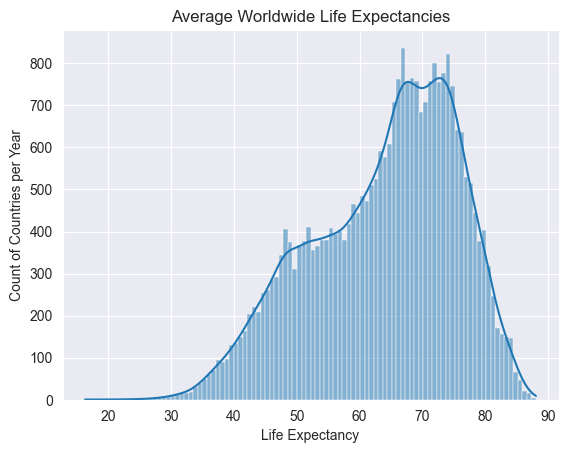

In [15]:
sns.histplot(data=world_data_life_exp, x="Life Expectancy", bins=100, kde=True)
plt.xlabel("Life Expectancy")
plt.title("Average Worldwide Life Expectancies")
plt.xlabel("Life Expectancy")
plt.ylabel("Count of Countries per Year")
plt.show()

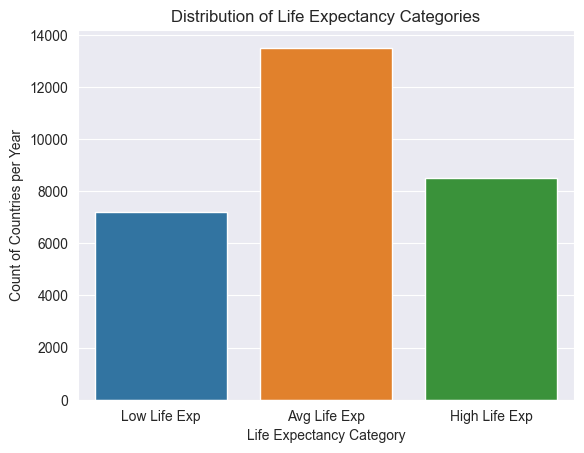

In [16]:
sns.countplot(x="Life Expectancy Category", data=world_data_life_exp)
plt.xlabel("Life Expectancy Category")
plt.ylabel("Count of Countries per Year")
plt.title("Distribution of Life Expectancy Categories")
plt.show()

In [17]:
world_data_life_exp[["Gender", "Life Expectancy"]].groupby("Gender").mean()

,Life Expectancy
Gender,
Female,66.226723
Male,61.627222


In [18]:
world_life_country_gender = world_data_life_exp[["Country", "Gender", "Life Expectancy"]].groupby(["Country", "Gender"]).mean()
world_life_country_gender

Life Expectancy
Country                     Gender                  
Afghanistan                 Female         50.344483
                            Male           48.146717
Africa Eastern and Southern Female         53.524745
                            Male           49.918876
Africa Western and Central  Female         48.986578
...                                              ...
Yemen, Rep.                 Male           51.074233
Zambia                      Female         52.867000
                            Male           49.347233
Zimbabwe                    Female         56.547600
                            Male           52.566617

[512 rows x 1 columns]

In [19]:
world_life_country_gender.reset_index(inplace=True)
gender_country = world_life_country_gender.pivot(index='Country', columns='Gender', values='Life Expectancy').reset_index()
gender_country.columns.name = None
gender_country.rename(columns = {
  "Female ": "Female Life Exp",
  "Male": "Male Life Exp"
}, inplace=True)

gender_country.head()

,Country,Female Life Exp,Male Life Exp
0,Afghanistan,50.344483,48.146717
1,Africa Eastern and Southern,53.524745,49.918876
2,Africa Western and Central,48.986578,46.646002
3,Albania,73.950033,69.613117
4,Algeria,64.760917,62.382417


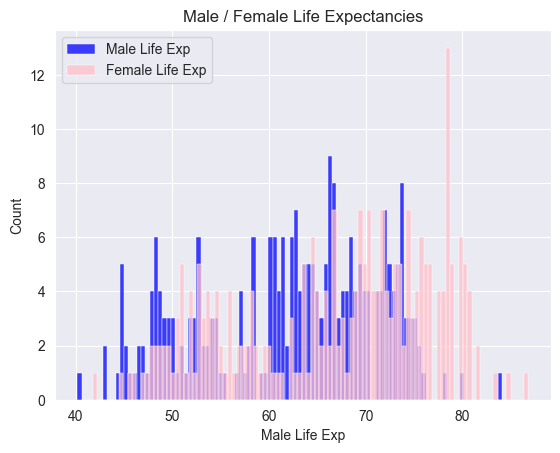

In [20]:
sns.histplot(gender_country["Male Life Exp"], bins=100, color='blue', label='Male Life Exp')
sns.histplot(gender_country["Female Life Exp"], bins=100, color='pink', label='Female Life Exp')
plt.title("Male / Female Life Expectancies")
plt.legend()
plt.show()

In [21]:
world_avs_country = world_data[["Country", "Life Expectancy", "Sucide Rate", "Births", "Employment", "Urban", "Rural", "Water", "Sanitation"]].groupby("Country").mean()
world_avs_country

,Life Expectancy,Sucide Rate,Births,Employment,Urban,Rural,Water,Sanitation
Country,,,,,,,,
Afghanistan,49.245600,4.835000,46.894867,0.977241,18.488183,81.511817,18.481513,34.430811
Africa Eastern and Southern,51.721811,13.965614,42.670056,2.839339,24.764205,75.235795,NaN,26.758921
Africa Western and Central,47.816290,9.227080,44.248727,1.545341,30.164630,69.835370,19.232976,28.036871
Albania,71.781575,7.545000,23.258450,4.591724,40.083033,59.916967,60.703133,94.695037
Algeria,63.571667,4.160000,34.143867,6.213448,52.257150,47.742850,73.761476,86.198087
...,...,...,...,...,...,...,...,...
West Bank and Gaza,71.634483,NaN,37.470833,6.123103,72.703233,27.296767,76.265818,93.732859
World,64.558577,14.590387,25.627091,3.407743,43.523538,56.476462,66.492867,66.336188
"Yemen, Rep.",52.544667,6.930000,46.792167,7.583448,21.745917,78.254083,NaN,49.420565


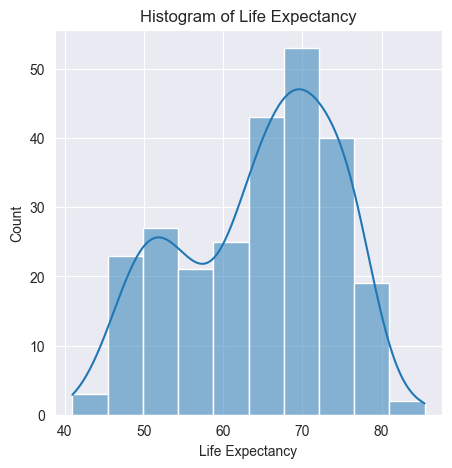

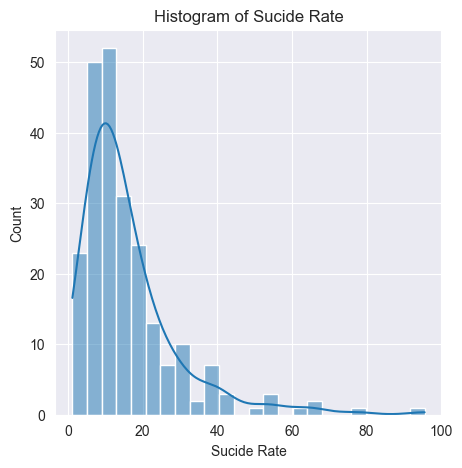

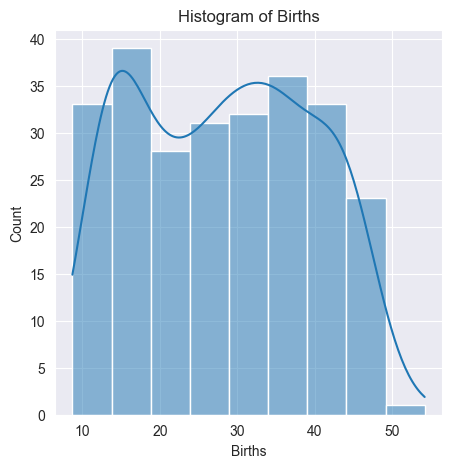

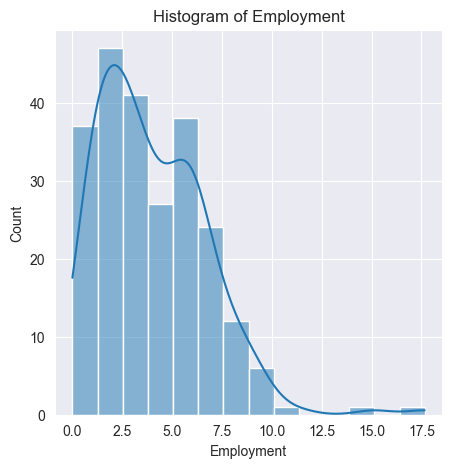

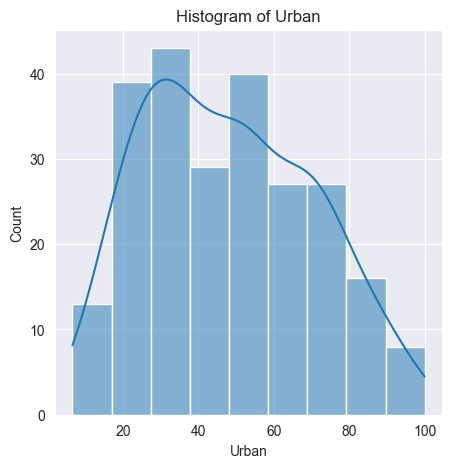

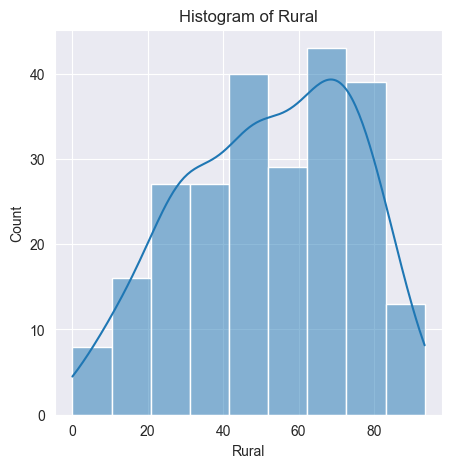

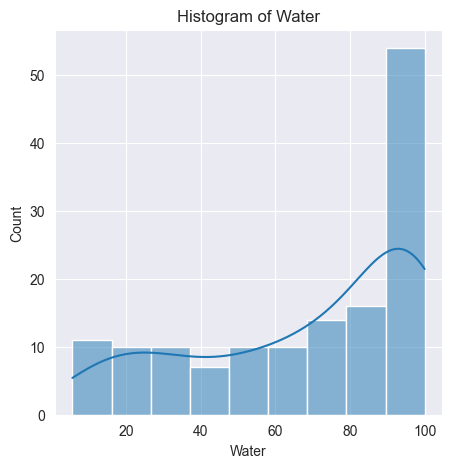

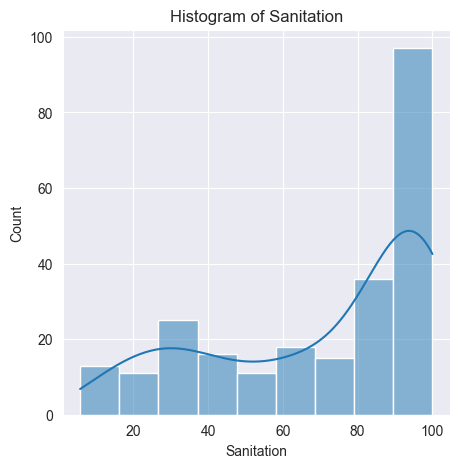

In [22]:
for column in world_avs_country.columns:
    plt.figure(figsize=(5,5))
    sns.histplot(world_avs_country[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()

<Axes: xlabel='Sucide Rate'>

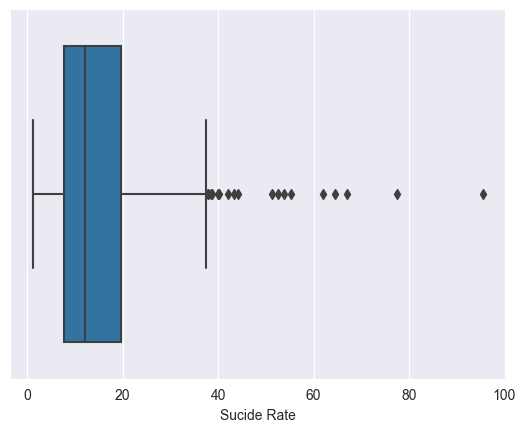

In [23]:
sns.boxplot(x='Sucide Rate', data=world_avs_country)

## Clustering (Pre-PCA)

In [24]:
#df=pd.read_csv('WorldData.csv').drop(['Unnamed: 0'],axis=1)
df = world_data

In [25]:
df.columns

Index(['Country', 'Year', 'Gender', 'Life Expectancy', '% Population',
       '% 0-14', 'Employment', 'Unemployment Rate', 'Death',
       'Infant Mortality', 'Sucide Rate', 'Births', 'Total Population',
       'Population 0-14', 'Population 15-64', 'Population 65+', 'Urban',
       'Rural', 'DPT', 'HepB', 'Measles', 'HIV', 'Water', 'Sanitation', 'TB',
       'Malaria', 'Hospital Beds', 'Physicians', 'Nurses', 'GDP',
       'GDP per Capita'],
      dtype='object')

In [26]:
df.fillna(method="ffill", inplace = True)
df.head()
df.tail()

,Country,Year,Gender,Life Expectancy,% Population,% 0-14,Employment,Unemployment Rate,Death,Infant Mortality,...,HIV,Water,Sanitation,TB,Malaria,Hospital Beds,Physicians,Nurses,GDP,GDP per Capita
29215,Zimbabwe,2015,Male,57.778,47.549390,44.853320,0.68,4.360000,396.789,46.6,...,66.0,30.385178,38.120646,242.0,97.646429,1.7,0.0817,1.3201,1.410192e+10,1093.653409
29216,Zimbabwe,2016,Male,58.565,47.569816,44.947669,0.70,4.360000,379.617,45.1,...,72.0,30.183683,37.529193,233.0,65.779400,1.7,0.0817,1.3201,1.410192e+10,1093.653409
29217,Zimbabwe,2017,Male,59.105,47.603041,44.860953,0.65,4.360000,362.446,44.2,...,82.0,29.997683,36.941673,221.0,108.549990,1.7,0.0817,1.3201,1.410192e+10,1093.653409
29218,Zimbabwe,2018,Male,59.501,47.643248,44.641152,0.60,4.360000,373.207,42.9,...,76.0,29.827913,36.357160,210.0,51.003781,1.7,0.0817,1.3201,1.410192e+10,1093.653409
29219,Zimbabwe,2019,Male,59.798,47.682673,44.369560,0.55,16.040001,369.227,42.1,...,90.0,29.673569,35.774337,199.0,51.003781,1.7,0.0817,1.3201,1.410192e+10,1093.653409


C:\Users\abart\AppData\Local\Temp\ipykernel_19968\2470291333.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = df.corr('spearman')


<Axes: >

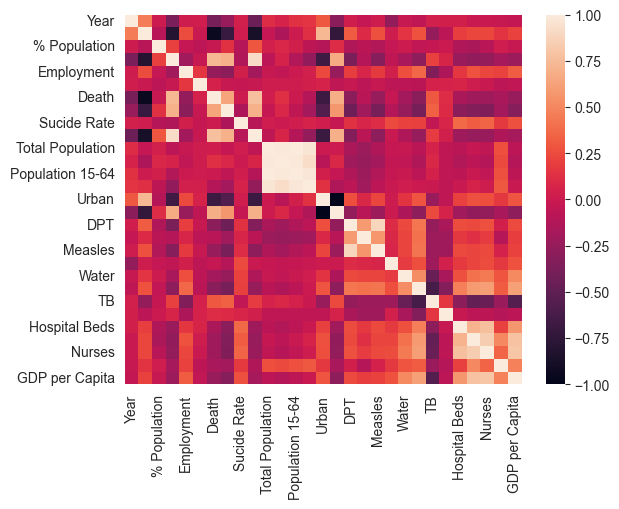

In [27]:
# Pearson Correlation
corrs = df.corr('spearman')
sns.heatmap(corrs)

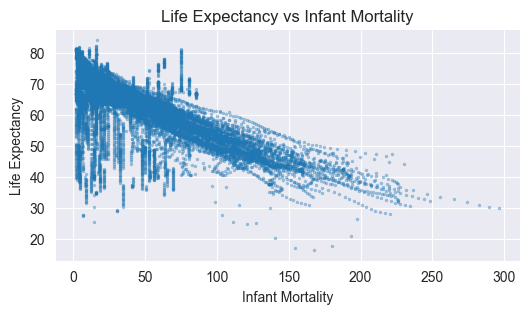

In [28]:
plt.figure(figsize=(6, 3))
sns.scatterplot(
  data=df,
  x="Infant Mortality",
  y="Life Expectancy",
  alpha=0.4,
  edgecolor=None,
  s=5)
plt.title('Life Expectancy vs Infant Mortality')
plt.xlabel('Infant Mortality')
plt.ylabel('Life Expectancy')
sns.despine()
plt.show()

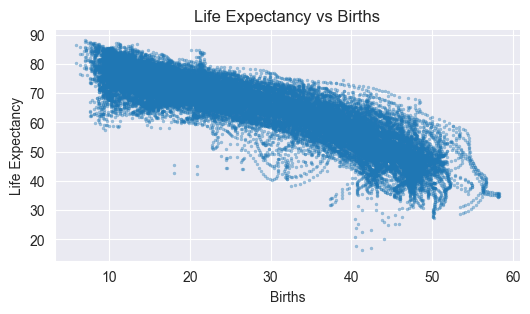

In [29]:
plt.figure(figsize=(6, 3))
sns.scatterplot(
  data=df,
  x="Births",
  y="Life Expectancy",
  alpha=0.4,
  edgecolor=None,
  s=5)
plt.title('Life Expectancy vs Births')
plt.xlabel('Births')
plt.ylabel('Life Expectancy')
sns.despine()
plt.show()

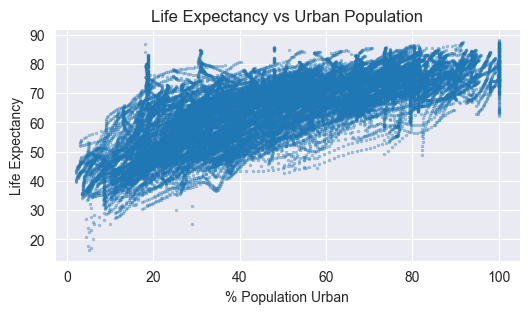

In [30]:
plt.figure(figsize=(6, 3))
sns.scatterplot(
  data=df,
  x="Urban",
  y="Life Expectancy",
  alpha=0.4,
  edgecolor=None,
  s=5)
plt.title('Life Expectancy vs Urban Population')
plt.xlabel('% Population Urban')
plt.ylabel('Life Expectancy')
sns.despine()
plt.show()

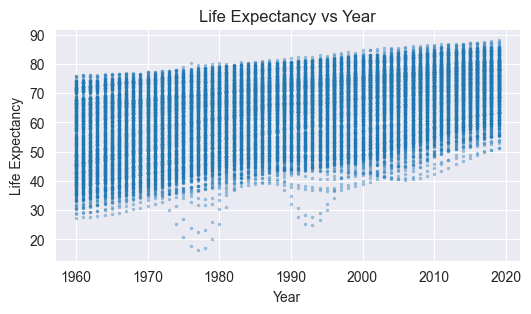

In [31]:
plt.figure(figsize=(6, 3))
sns.scatterplot(
  data=df,
  x="Year",
  y="Life Expectancy",
  alpha=0.4,
  edgecolor=None,
  s=5)
plt.title('Life Expectancy vs Year')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
sns.despine()
plt.show()

Before PCA: Clustering using gaussian mixture models.

In [32]:
world_data = pd.get_dummies(
  df,
  columns=['Country',
           'Gender']
)
world_data.dropna(inplace=True)
world_data.head()

,Year,Life Expectancy,% Population,% 0-14,Employment,Unemployment Rate,Death,Infant Mortality,Sucide Rate,Births,...,"Country_Venezuela, RB",Country_Vietnam,Country_Virgin Islands (U.S.),Country_West Bank and Gaza,Country_World,"Country_Yemen, Rep.",Country_Zambia,Country_Zimbabwe,Gender_Female,Gender_Male
14658,2008,58.626,51.315132,48.124577,0.56,2.65,281.258,73.3,5.1,41.949,...,0,0,0,0,0,0,0,0,0,1
14659,2009,59.159,51.220829,48.185173,0.69,2.65,276.279,70.6,4.8,40.903,...,0,0,0,0,0,0,0,0,0,1
14660,2010,59.683,51.175242,48.153913,0.84,2.65,271.299,67.9,4.6,39.829,...,0,0,0,0,0,0,0,0,0,1
14661,2011,60.190,51.184217,47.626942,1.01,2.65,266.320,65.4,4.5,38.750,...,0,0,0,0,0,0,0,0,0,1
14662,2012,60.675,51.232888,46.980615,1.21,1.36,261.340,63.0,4.3,37.690,...,0,0,0,0,0,0,0,0,0,1


Now clustering *without* PCA:

## Performing PCA

In [33]:
scaler = StandardScaler()
scaled_world_data = scaler.fit_transform(world_data)

In [34]:
normalized_world_data = normalize(scaled_world_data)
normalized_world_data = pd.DataFrame(normalized_world_data)
normalized_world_data.head()

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,286
0,0.029821,-0.008099,0.017671,0.035872,-0.036186,-0.024771,0.005160,0.016106,-0.021869,0.029225,...,-0.001825,-0.001825,-0.001825,-0.001289,-0.001825,-0.001825,-0.001825,-0.001825,0.0,0.0
1,0.031471,-0.006689,0.016509,0.036050,-0.034841,-0.024779,0.003918,0.014389,-0.022545,0.026913,...,-0.001825,-0.001825,-0.001825,-0.001289,-0.001825,-0.001825,-0.001825,-0.001825,0.0,0.0
2,0.033127,-0.005303,0.015952,0.035982,-0.033291,-0.024791,0.002676,0.012674,-0.023001,0.024541,...,-0.001826,-0.001826,-0.001826,-0.001290,-0.001826,-0.001826,-0.001826,-0.001826,0.0,0.0
3,0.034786,-0.003960,0.016071,0.034548,-0.031531,-0.024803,0.001433,0.011085,-0.023236,0.022157,...,-0.001827,-0.001827,-0.001827,-0.001291,-0.001827,-0.001827,-0.001827,-0.001827,0.0,0.0
4,0.036422,-0.002673,0.016672,0.032762,-0.029437,-0.031095,0.000189,0.009552,-0.023679,0.019799,...,-0.001827,-0.001827,-0.001827,-0.001291,-0.001827,-0.001827,-0.001827,-0.001827,0.0,0.0


In [35]:
pca = PCA(n_components=2)
X_princ = pca.fit_transform(normalized_world_data)
X_princ = pd.DataFrame(X_princ)
X_princ.columns = ['P1', 'P2']
X_princ.head()

,P1,P2
0,-0.101647,0.034634
1,-0.098628,0.035314
2,-0.094311,0.034818
3,-0.089894,0.034707
4,-0.087692,0.036384


## Clustering (Post-PCA)

In [36]:
def SelBest(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [37]:
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [38]:
n_clusters=np.arange(2, 8)
iterations=10
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(X_princ, test_size=0.5)
        
        gmm_train=GaussianMixture(n, n_init=2).fit(train) 
        gmm_test=GaussianMixture(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

c:\Users\abart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\abart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\abart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\abart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\abart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Gaussian

In [39]:
# covariance types to try
cov_types = ['full', 'tied', 'diag', 'spherical']

results = []

for n_clusters in range(2, 8):
    for cov in cov_types:
        gmm = GaussianMixture(n_components=n_clusters, covariance_type=cov)
        gmm.fit(X_princ)
        labels = gmm.predict(X_princ)
        silhouette_avg = silhouette_score(X_princ, labels)
        results.append({
            'n_clusters': n_clusters,
            'covariance_type': cov,
            'silhouette_score': silhouette_avg
        })
results_df = pd.DataFrame(results)


In [40]:
results_df

,n_clusters,covariance_type,silhouette_score
0,2,full,0.426119
1,2,tied,0.431402
2,2,diag,0.426023
3,2,spherical,0.409978
4,3,full,0.477542
5,3,tied,0.480027
6,3,diag,0.482229
7,3,spherical,0.481005
8,4,full,0.383953
9,4,tied,0.383720


I want to use __3__ diagonal clusters. The silhouette score is as follows:

| Iteration | Num Clusters | Covariance Type | Silhouette Score |
| --------- | ------------ | --------------- | ---------------- |
| 6	| 3	| diagonal	| 0.482263 |

In [42]:
gmm = GaussianMixture(n_components = 3, covariance_type = "diag")
gmm.fit(X_princ)

GaussianMixture(covariance_type='diag', n_components=3)

In [43]:
gmm.predict(X_princ)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [44]:
gmm.sample(10)

(array([[-0.01812975,  0.06274663],
        [ 0.30448027,  0.05932279],
        [ 0.24817141, -0.07941575],
        [ 0.32452534, -0.0466127 ],
        [ 0.12567901,  0.08653132],
        [-0.17322565,  0.02171743],
        [-0.08602874, -0.01552713],
        [-0.10692137,  0.03501091],
        [-0.03576478,  0.00143922],
        [-0.06123114, -0.1298194 ]]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))

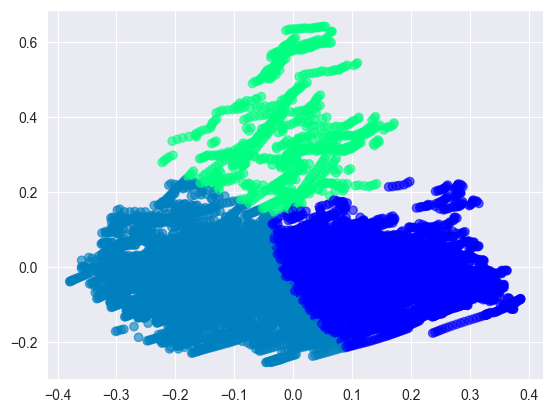

In [45]:
plt.scatter(
  X_princ['P1'],
  X_princ['P2'],
  c = GaussianMixture(n_components = 3).fit_predict(X_princ),
  cmap = plt.cm.winter,
  alpha = 0.6
)
plt.show()

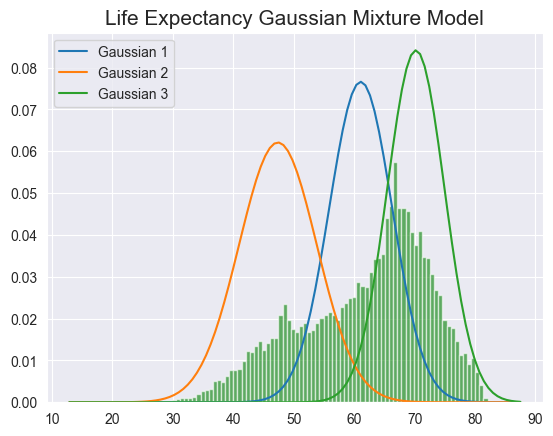

In [47]:
life_expectancy = world_data["Life Expectancy"]

gmm = GaussianMixture(n_components=3)
gmm.fit(life_expectancy.values.reshape(-1, 1))

plt.hist(life_expectancy, bins=100, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

for i in range(gmm.n_components):
    mean = gmm.means_[i][0]
    std = np.sqrt(gmm.covariances_[i][0])

    y = norm.pdf(x, mean, std)

    plt.plot(x, y, label=f'Gaussian {i+1}')
plt.title("Life Expectancy Gaussian Mixture Model", fontsize=15)
plt.legend()
plt.show()